In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import carrier_colors, nice_carrier_names, policy_colors

In [21]:
z = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_zonal.csv'
n = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_national.csv'

z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
n = pd.read_csv(n, parse_dates=True, index_col=[0,1])

C:\Users\lukas\AppData\Local\Temp\ipykernel_18812\301094810.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_18812\301094810.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_18812\301094810.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  n = pd.read_csv(n, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_18812\301094810.py:5: UserWarning: Cou

In [22]:
p = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex.csv'
p = pd.read_csv(p, parse_dates=True, index_col=[0,1,2])

C:\Users\lukas\AppData\Local\Temp\ipykernel_18812\2131312563.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  p = pd.read_csv(p, parse_dates=True, index_col=[0,1,2])
C:\Users\lukas\AppData\Local\Temp\ipykernel_18812\2131312563.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  p = pd.read_csv(p, parse_dates=True, index_col=[0,1,2])
C:\Users\lukas\AppData\Local\Temp\ipykernel_18812\2131312563.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  p = pd.read_csv(p, parse_dates=True, index_col=[0,1,2])


In [23]:
idx = pd.IndexSlice

keepers = ['bid_cost', 'cfd', 'offer_cost', 'roc', 'wholesale']

z = p.loc[idx[:,'zonal', keepers], :]
n = p.loc[idx[:,'national', keepers], :]

z.index = z.index.droplevel(1)
n.index = n.index.droplevel(1)

# Rename index values in level 1 for both dataframes
rename_dict = {
    'cfd': 'cfd_revenue',
    'roc': 'roc_revenue',
    'wholesale': 'wholesale_revenue'
}

# Apply renaming to z dataframe
z.index = pd.MultiIndex.from_tuples(
    [(asset, rename_dict.get(revenue_type, revenue_type)) 
     for asset, revenue_type in z.index],
    names=z.index.names
)

# Apply renaming to n dataframe
n.index = pd.MultiIndex.from_tuples(
    [(asset, rename_dict.get(revenue_type, revenue_type)) 
     for asset, revenue_type in n.index],
    names=n.index.names
)

n.sort_index(inplace=True)
z.sort_index(inplace=True)

C:\Users\lukas\AppData\Local\Temp\ipykernel_18812\3570653476.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n.sort_index(inplace=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_18812\3570653476.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z.sort_index(inplace=True)


In [24]:
cfd = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'cfd_strike_prices.csv', index_col=0)

In [25]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'prepared_bmus.csv', index_col=0)

import yaml

with open(Path.cwd().parent / 'data' / 'interconnection_helpers.yaml', 'r') as f:
    inter_bmu = yaml.safe_load(f)['interconnection_mapper']

intercon_lats = []

for i, (key, item) in enumerate(inter_bmu.items()):

    if key == 'Nemo':
        intercon_lats.append(0)
        continue

    lat = bmus.loc[bmus.index.str.startswith(item[0]+'-'), 'lat'].dropna().astype(float).mean()
    intercon_lats.append(lat)

intercon_lats = pd.Series(intercon_lats, index=inter_bmu.keys())

intercon_lats.loc['EastWest'] = 53.23
intercon_lats.loc['Moyle'] = 55.07
intercon_lats.loc['Nemo'] = 51.297

intercon_lats = intercon_lats.to_frame().rename(columns={0: 'lat'})

In [26]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'prepared_bmus.csv', index_col=0)

bmus = bmus.loc[~(bmus['lat'] == 'distributed')]
bmus.loc[:,'lat'] = bmus['lat'].astype(float)

bmu_carriers = pd.concat((
    bmus['carrier'],
    pd.Series('interconnector', intercon_lats.index)
))

bmus = pd.concat([bmus['lat'], intercon_lats])

In [27]:
nice_revenue_names = {
    "wholesale_revenue": "Revenue Change (%) \n Wholesale",
    "roc_revenue": "Revenue Change (%) \n ROC",
    "cfd_revenue": "Revenue Change (%) \n Contracts for Differences",
}

In [28]:
def plot_carrier_share(series, base_ax, coords):
    """
    Plots the carrier share distribution as a horizontal bar on an additional axis.

    Parameters:
      series: Pandas Series with carriers as index and fractional share values.
      base_ax: A matplotlib Axes instance. An additional axis will be added to its figure.
      coords: A tuple or list of [left, bottom, width, height] in figure coordinates defining the new axis extent.
    """
  
      # new_ax = base_ax.figure.add_axes(coords)
    # new_ax = base_ax.add_axes(coords)
    new_ax = base_ax.inset_axes(coords)
    
    cumulative = 0  # keep track of the left boundary for each segment
    for carrier, share in series.items():
        # Convert the fractional share to a percentage width (since 1 -> 100%)
        segment_width = share * 100
        # Get the assigned color for this carrier, defaulting to 'gray' if missing
        color = carrier_colors.get(carrier, 'gray')
        # Draw a horizontal bar for this segment with no edge, for a smooth look
        new_ax.barh(0, width=segment_width, left=cumulative, height=1,
                    color=color, edgecolor='none')
        new_ax.axvline(cumulative, c='k', lw=0.5)

        cumulative += segment_width

    # Adjust the x-axis to run from 0 to 100 with ticks every 20%
    new_ax.set_xlim(0, 100)
    new_ax.set_xticks(list(range(0, 101, 20)))
    new_ax.set_yticks([])  # remove y-axis ticks
    xtick_labels = list(new_ax.get_xticks())
    xtick_labels[-1] = '100%'
    new_ax.set_xticklabels(xtick_labels)

    # new_ax.set_xlabel('(%)')
    # new_ax.set_title('Carrier Share Distribution')

In [29]:
fp = pd.read_excel(
    Path.cwd() / 'systemaveragepriceofgasdataset130225.xlsx',
    sheet_name=3,
    parse_dates=True,
    index_col=0,
    skiprows=1
    )

def process(df):

    df = (
        df.iloc[4:]
        .rename(
        columns={
            'Unnamed: 1': 'day_price',
            'Unnamed: 2': 'before_week_average',
        })
        .replace('[x]', np.nan)
        ['day_price']
        )
    df.index.name = 'date'
    df.index = pd.to_datetime(df.index)
    return df * 10

fp = process(fp)

thermal_plant_eta = 0.52
balancing_markup = 30

C:\Users\lukas\AppData\Local\Temp\ipykernel_18812\3361897111.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fp = pd.read_excel(
C:\Users\lukas\AppData\Local\Temp\ipykernel_18812\3361897111.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace('[x]', np.nan)


In [30]:
dispatch = pd.read_csv(
    Path.cwd().parent / 'summaries' / 'total_unit_dispatch_flex.csv', index_col=[0,1,2]
)

dispatch

2022-01-01  2022-01-02  2022-01-03  2022-01-04  \
ABERU-1 national redispatch       23.00         0.0         0.0         0.0   
                 wholesale         0.00         0.0         0.0         0.0   
        zonal    redispatch        0.00         0.0         0.0         0.0   
                 wholesale         0.00         0.0         0.0         0.0   
ABRBO-1 national redispatch     1923.25      1612.5      1715.5      2165.5   
...                                 ...         ...         ...         ...   
LITRB-1 zonal    wholesale          NaN         NaN         NaN         NaN   
Viking  national redispatch         NaN         NaN         NaN         NaN   
                 wholesale          NaN         NaN         NaN         NaN   
        zonal    redispatch         NaN         NaN         NaN         NaN   
                 wholesale          NaN         NaN         NaN         NaN   

                             2022-01-05   2022-01-06  2022-01-07  2022-01-08  \
ABERU-1 national redispatch        0.00    54.256203         0.0         0.0   
                 wholesale         0.00     0.000000         0.0         0.0   
        zonal    redispatch        0.00     0.000000         0.0         0.0   
                 wholesale         0.00     0.000000         0.0         0.0   
ABRBO-1 national redispatch     1584.25  1439.750000       711.5       919.0   
...                                 ...          ...         ...         ...   
LITRB-1 zonal    wholesale          NaN          NaN         NaN         NaN   
Viking  national redispatch         NaN          NaN         NaN         NaN   
                 wholesale          NaN          NaN         NaN         NaN   
        zonal    redispatch         NaN          NaN         NaN         NaN   
                 wholesale          NaN          NaN         NaN         NaN   

                             2022-01-09   2022-01-10  ...    2024-12-22  \
ABERU-1 national redispatch         0.0   169.037103  ...  0.000000e+00   
                 wholesale          0.0   169.037103  ...  0.000000e+00   
        zonal    redispatch         0.0   169.037103  ...  0.000000e+00   
                 wholesale          0.0   169.037103  ...  0.000000e+00   
ABRBO-1 national redispatch       215.0  1417.750000  ...  1.512500e+03   
...                                 ...          ...  ...           ...   
LITRB-1 zonal    wholesale          NaN          NaN  ... -1.776357e-15   
Viking  national redispatch         NaN          NaN  ...  2.069011e+04   
                 wholesale          NaN          NaN  ...  2.069011e+04   
        zonal    redispatch         NaN          NaN  ...  2.302650e+04   
                 wholesale          NaN          NaN  ...  2.302650e+04   

                               2024-12-23    2024-12-24   2024-12-25  \
ABERU-1 national redispatch      0.000000     88.000000   160.000000   
                 wholesale       0.000000      0.000000     0.000000   
        zonal    redispatch      0.000000     64.000000     0.000000   
                 wholesale       0.000000      0.000000     0.000000   
ABRBO-1 national redispatch    687.000000    565.750000   848.500000   
...                                   ...           ...          ...   
LITRB-1 zonal    wholesale       0.000000      0.000000     0.000000   
Viking  national redispatch  15494.953986 -11966.667185  5466.160182   
                 wholesale   15494.953986 -11966.667185  5466.160182   
        zonal    redispatch  16314.310089  -7585.950198  9431.573663   
                 wholesale   16314.310089  -7585.950198  9431.573663   

                               2024-12-26    2024-12-27    2024-12-28  \
ABERU-1 national redispatch     88.000000    105.648706    123.500000   
                 wholesale      48.000000    105.648706     91.000000   
        zonal    redispatch     80.000000    105.648706    110.500000   
                 wholesale      48.000000    105.648706     9

In [31]:
from tqdm import tqdm

offers = []

for day in tqdm(pd.date_range(start='2022-01-01', end='2024-12-31', freq='D').strftime('%Y-%m-%d')):
    try:
        offers.append(pd.read_csv(
            Path.cwd().parent / 'data' / 'base' / day / 'offers.csv', index_col=[0,1], parse_dates=[0]))
    except FileNotFoundError:
        continue

offers = pd.concat(offers)

offers = offers.loc[idx[:, 'price'], :]
offers.index = offers.index.droplevel(1)
offers.index = offers.index.strftime('%Y-%m-%d %H:%M:%S')
offers = offers.groupby(offers.index.str[:10]).mean()

100%|██████████| 1096/1096 [00:07<00:00, 148.01it/s]


In [32]:
import os

thermal_costs = []
tc_path = Path.cwd().parent / 'data' / 'prerun' / 'thermal_costs'
for fn in tqdm(os.listdir(tc_path)):

    if fn.endswith('.csv'):
        tc = pd.read_csv(tc_path / fn, index_col=0).rename(columns={'0': fn.split('.')[0]})
        thermal_costs.append(tc)

thermal_costs = pd.concat(thermal_costs, axis=1)

100%|██████████| 173/173 [00:00<00:00, 659.74it/s]


In [33]:
bmus_alldata = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'prepared_bmus.csv', index_col=0)

def get_units(carrier):
    if isinstance(carrier, list):
        return bmus_alldata.loc[bmus_alldata.carrier.isin(carrier)].index
    else:
        units = bmus_alldata.loc[bmus_alldata.carrier.str.contains(carrier)].index

    return units

thermal_units = get_units(['fossil', 'biomass', 'coal'])

In [34]:
fp

date
2018-01-01    17.083
2018-01-02    17.331
2018-01-03    17.663
2018-01-04    17.719
2018-01-05    17.601
               ...  
2025-02-05    45.794
2025-02-06    46.270
2025-02-07    47.141
2025-02-08    48.027
2025-02-09    47.429
Name: day_price, Length: 2597, dtype: float64

In [35]:
def get_plant_expenses(dispatch, mode, fp, thermal_plant_eta, balancing_markup):

    idx = pd.IndexSlice

    ss = dispatch.loc[idx[:, mode, :], :].copy()
    ss.index = ss.index.droplevel(1)

    bal_ss = ss.loc[idx[:, 'redispatch'], :]
    bal_ss.index = bal_ss.index.droplevel(1)

    # Calculate total MWh delivered per unit
    total_mwh_delivered = ss.groupby(level=0).sum()
    
    ss = ss.groupby(level=0).sum()

    hold_fp = fp.copy()
    hold_fp.index = fp.index.strftime('%Y-%m-%d')

    # Create a result DataFrame with the same shape as ss
    result = pd.DataFrame(index=ss.index, columns=ss.columns)

    # Multiply all values in ss by the corresponding date values in fp
    # First align the columns of ss with the index of fp
    common_dates = ss.columns.intersection(hold_fp.index)

    result = pd.DataFrame(index=ss.index, columns=ss.columns)

    result.loc[:, common_dates] = (
        ss.loc[:, common_dates].values *
        hold_fp.loc[common_dates].values.reshape(1, -1) /
        thermal_plant_eta
    )
    
    # Calculate total expenses per unit
    total_expenses = result.sum(axis=1).add(bal_ss.loc[result.index].sum(axis=1).mul(balancing_markup))
    
    # Calculate expenses per MWh delivered
    # Avoid division by zero
    total_mwh_delivered_sum = total_mwh_delivered.sum(axis=1)
    expenses_per_mwh = total_expenses.div(total_mwh_delivered_sum.where(total_mwh_delivered_sum > 0, np.nan))
    
    return expenses_per_mwh


zonal_expenses = get_plant_expenses(
    dispatch.loc[idx[thermal_units, :, :], :],
    'zonal',
    fp,
    thermal_plant_eta,
    balancing_markup
)# .mul(1e-6)

national_expenses = get_plant_expenses(
    dispatch.loc[idx[thermal_units, :, :], :],
    'national',
    fp,
    thermal_plant_eta,
    balancing_markup
)# .mul(1e-6)

In [36]:
nd = dispatch.loc[idx[:, 'national', :], :].groupby(level=0).sum()
n_mwh_delivered = nd.groupby(nd.index.str[:5]).sum().sum(axis=1)

zd = dispatch.loc[idx[:, 'zonal', :], :].groupby(level=0).sum()
z_mwh_delivered = zd.groupby(zd.index.str[:5]).sum().sum(axis=1)

In [37]:
# National expenses and revenue
n_exp = national_expenses.sort_values(ascending=False)
n_exp = n_exp.loc[n_exp > 0]
n_exp = n_exp.groupby(n_exp.index.str[:5]).sum()

n_rev = n.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)
# Group by first 5 characters of index and sum
n_rev_grouped = n_rev.groupby(n_rev.index.str[:5]).sum()

# Get total MWh delivered for each plant group
# Calculate revenue per MWh delivered
n_rev = (
    n_rev_grouped.loc[n_exp.index]
    .div(
        n_mwh_delivered.loc[n_exp.index]
        .where(n_mwh_delivered.loc[n_exp.index] > 0, np.nan)
    )# .mul(1e-6)
)

national_comparison = pd.concat((n_exp.rename('expenses'), n_rev.rename('revenue')), axis=1)
national_comparison['expenses'] *= -1.

# national_comparison['diff'] = national_comparison['revenue'] - national_comparison['expenses']
national_comparison['gap'] = - 1.1 * national_comparison['expenses'] - national_comparison['revenue']
national_comparison['profit'] = national_comparison.sum(axis=1)

print(national_comparison.head())

         expenses     revenue         gap     profit
ABERU -129.728097  118.890480   23.810427   12.97281
AG-NH  -72.444611   63.715531    15.97354   7.244461
BRGDG -126.154582  109.831391   28.938649  12.615458
BRIDU  -117.24075  117.211364   11.753461  11.724075
CARR-  -229.40172   83.899690  168.442202  22.940172


In [49]:
# Zonal expenses and revenue
z_exp = zonal_expenses.sort_values(ascending=False)
z_exp = z_exp.loc[z_exp > 0]
z_exp = z_exp.groupby(z_exp.index.str[:5]).sum()

z_rev = z.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)
# Group by first 5 characters of index and sum
z_rev_grouped = z_rev.groupby(z_rev.index.str[:5]).sum()

# Calculate revenue per MWh delivered
z_rev = z_rev_grouped.div(z_mwh_delivered.loc[z_exp.index].where(z_mwh_delivered.loc[z_exp.index] > 0, np.nan)).loc[z_exp.index]# .mul(1e-6)
z_rev = z_rev.groupby(z_rev.index.str[:5]).sum().loc[z_exp.index]# .mul(1e-6)

zonal_comparison = pd.concat((z_exp.rename('expenses').mul(-1), z_rev.rename('revenue')), axis=1)

zonal_comparison['profit'] = zonal_comparison.sum(axis=1).add(national_comparison['gap'].clip(lower=0))
# zonal_comparison['diff'] = zonal_comparison['revenue'] - zonal_comparison['expenses']

In [50]:
inter = thermal_units.str[:5].intersection(zonal_comparison.index)

profit_change = zonal_comparison['profit'].div(national_comparison['profit']).loc[inter].sort_values()

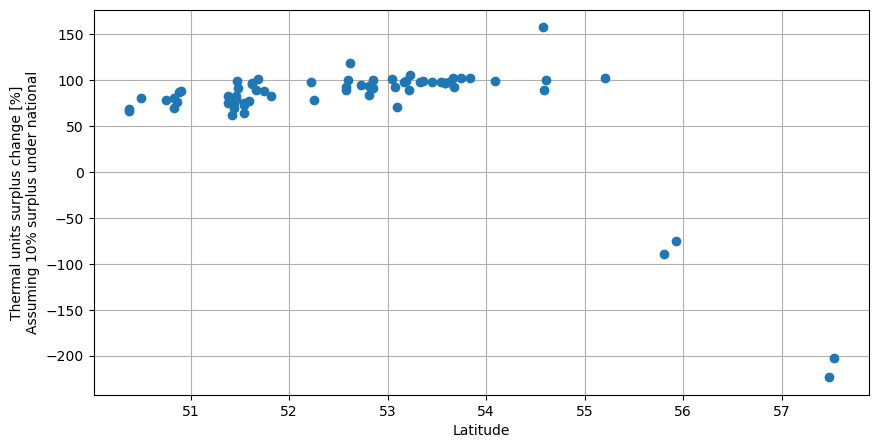

In [51]:
short_bmus = bmus.groupby(bmus.index.str[:5]).first()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(short_bmus.loc[profit_change.index], profit_change.values * 100)
ax.set_ylabel('Thermal units surplus change [%]\nAssuming 10% surplus under national')

ax.set_xlabel('Latitude')
ax.grid(True)
ax.set_axisbelow(True)

plt.show()

In [58]:
profit_change.sort_values()

MARK-   -2.234817
PEHE-   -2.021576
AG-NH   -0.891379
GRMO-   -0.753264
INDQ-    0.626084
           ...   
KILLP    1.026215
SCCL-    1.026386
CNQPS    1.055041
SUTB-    1.188413
TSREP    1.578361
Name: profit, Length: 66, dtype: object

In [60]:
national_comparison.loc[['PEHE-', 'MARK-', 'TSREP']]

,expenses,revenue,gap,profit
PEHE-,-118.363074,132.141818,-1.942436,11.836307
MARK-,-99.211366,112.044473,-2.91197,9.921137
TSREP,-75.320128,87.244575,-4.392435,7.532013


In [61]:
zonal_comparison.loc[['PEHE-', 'MARK-', 'TSREP']]

,expenses,revenue,profit
PEHE-,-123.470494,99.542499,-23.927995
MARK-,-105.145189,82.973266,-22.171924
TSREP,-74.846629,86.734863,11.888234


In [ ]:
national_comparison['profit']






         expenses     revenue       diff
ABERU  129.728097  118.890480 -10.837617
AG-NH   72.444611   63.715531  -8.729079
BRGDG  126.154582  109.831391 -16.323191
BRIDU   117.24075  117.211364  -0.029386
CARR-   229.40172   83.899690 -145.50203
         expenses     revenue        diff
ABERU  128.941781  114.283816  -14.657965
AG-NH   73.945927   51.514827    -22.4311
BRGDG  125.731298  109.226769  -16.504529
BRIDU   116.27304  116.211888   -0.061153
CARR-  228.492648   82.679945 -145.812702


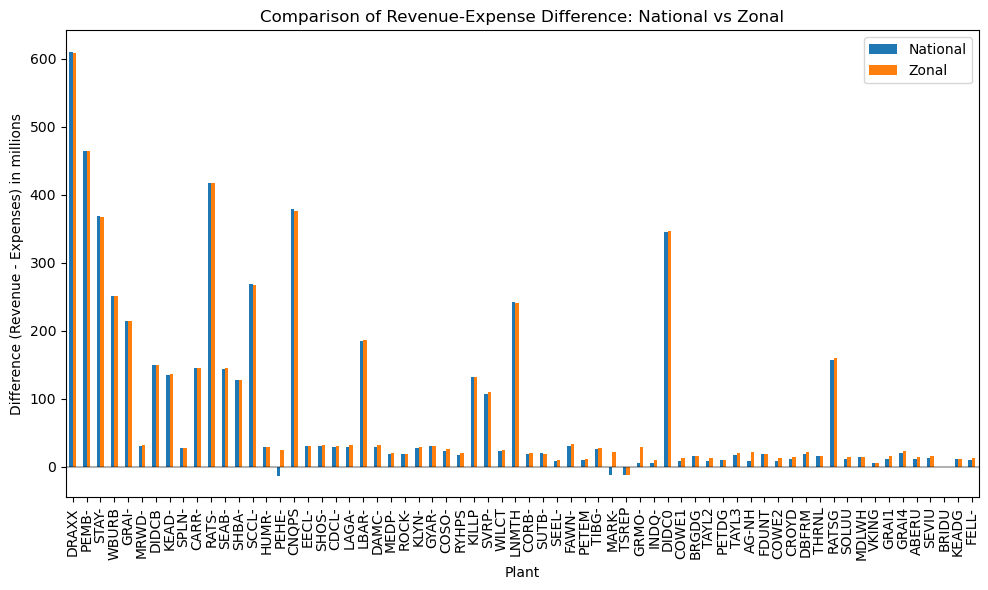

In [208]:
print(national_comparison.head())
print(zonal_comparison.head())

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'National': national_comparison['diff'],
    'Zonal': zonal_comparison['diff']
})

# Sort by national dispatch volume
plot_data = plot_data.loc[n_mwh_delivered.sort_values(ascending=False).index.intersection(plot_data.index)]

# Create a grouped bar plot
ax = plot_data.mul(-1).plot(kind='bar', figsize=(10, 6))

ax.set_xlabel('Plant')
ax.set_ylabel('Difference (Revenue - Expenses) in millions')

ax.set_title('Comparison of Revenue-Expense Difference: National vs Zonal')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [206]:
dispatch.loc[dispatch.index.get_level_values(0).str.startswith('AG-NH')]

2022-01-01  2022-01-02  2022-01-03  2022-01-04  \
AG-NHAV02 national redispatch         NaN         NaN         NaN         NaN   
                   wholesale          NaN         NaN         NaN         NaN   
          zonal    redispatch         NaN         NaN         NaN         NaN   
                   wholesale          NaN         NaN         NaN         NaN   

                               2022-01-05  2022-01-06  2022-01-07  2022-01-08  \
AG-NHAV02 national redispatch         NaN         NaN         NaN         NaN   
                   wholesale          NaN         NaN         NaN         NaN   
          zonal    redispatch         NaN         NaN         NaN         NaN   
                   wholesale          NaN         NaN         NaN         NaN   

                               2022-01-09  2022-01-10  ...  2024-12-22  \
AG-NHAV02 national redispatch         NaN         NaN  ...         0.0   
                   wholesale          NaN         NaN  ...         0.0   
          zonal    redispatch         NaN         NaN  ...         0.0   
                   wholesale          NaN         NaN  ...         0.0   

                               2024-12-23  2024-12-24  2024-12-25  2024-12-26  \
AG-NHAV02 national redispatch  254.000000         0.0         0.0       717.0   
                   wholesale   307.500000       245.0        23.0       763.0   
          zonal    redispatch  247.013613         0.0         0.0       717.0   
                   wholesale   162.000000         0.0         0.0       763.0   

                               2024-12-27  2024-12-28  2024-12-29  2024-12-30  \
AG-NHAV02 national redispatch   944.53545  680.243621         0.0        0.00   
                   wholesale    944.53545  855.500000         0.0      461.25   
          zonal    redispatch   944.53545  777.770272         0.0        0.00   
                   wholesale    944.53545  604.000000         0.0        0.00   

                               2024-12-31  
AG-NHAV02 national redispatch         0.0  
                   wholesale        727.5  
          zonal    redispatch         0.0  
                   wholesale          0.0  

[4 rows x 1076 columns]

In [73]:
# Initialize the dataframes for demonstration
n_total = n.replace(np.nan, 0).loc[thermal_units]
z_total = z.replace(np.nan, 0).loc[thermal_units]

n_total.columns = pd.to_datetime(n_total.columns)
z_total.columns = pd.to_datetime(z_total.columns)

In [81]:



def get_quarterly_data(start_year=2022, end_year=2024):
    """
    Extract quarterly data for each unit including wholesale revenue, redispatch revenue,
    and dispatch volumes for both national and zonal markets.
    
    Returns:
        DataFrame: Quarterly aggregated data for each unit
    """
    # Initialize dataframes
    n_total = n.replace(np.nan, 0).loc[thermal_units]
    z_total = z.replace(np.nan, 0).loc[thermal_units]
    
    # Create empty list to store quarterly data
    quarterly_data = []
    
    for year in range(start_year, end_year + 1):
        for quarter in range(1, 5):
            # Define quarter start and end dates
            if quarter == 1:
                start_date = f"{year}-01-01"
                end_date = f"{year}-03-31"
            elif quarter == 2:
                start_date = f"{year}-04-01"
                end_date = f"{year}-06-30"
            elif quarter == 3:
                start_date = f"{year}-07-01"
                end_date = f"{year}-09-30"
            else:  # quarter == 4
                start_date = f"{year}-10-01"
                end_date = f"{year}-12-31"
            
            # Filter data for the quarter
            n_quarter = n_total.loc[:, start_date:end_date].sum(axis=1)
            z_quarter = z_total.loc[:, start_date:end_date].sum(axis=1)

            # Get dispatch data - need to handle the 3-level index
            dispatch_quarter = dispatch.loc[:, start_date:end_date].sum(axis=1)
            
            # Create a multi-index for the units
            for unit in n_total.index.get_level_values(0).unique():
                try:
                    # Get national data
                    n_wholesale = n_quarter.loc[idx[unit, 'wholesale_revenue']]
                    n_redispatch = n_quarter.loc[idx[unit, 'offer_cost']]
                    
                    # Get zonal data
                    z_wholesale = z_quarter.loc[idx[unit, 'wholesale_revenue']]
                    z_redispatch = z_quarter.loc[idx[unit, 'offer_cost']]
                    
                    # Get dispatch volumes
                    n_dispatch_wholesale = dispatch_quarter.loc[idx[unit, 'national', 'wholesale']]
                    n_dispatch_redispatch = dispatch_quarter.loc[idx[unit, 'national', 'redispatch']]
                    z_dispatch_wholesale = dispatch_quarter.loc[idx[unit, 'zonal', 'wholesale']]
                    z_dispatch_redispatch = dispatch_quarter.loc[idx[unit, 'zonal', 'redispatch']]
                    
                    quarterly_data.append({
                        'unit': unit,
                        'year': year,
                        'quarter': quarter,
                        'period': f"Q{quarter} {year}",
                        'n_wholesale_revenue': n_wholesale,
                        'n_redispatch_revenue': n_redispatch,
                        'z_wholesale_revenue': z_wholesale,
                        'z_redispatch_revenue': z_redispatch,
                        'n_wholesale_dispatch': n_dispatch_wholesale,
                        'n_redispatch_dispatch': n_dispatch_redispatch,
                        'z_wholesale_dispatch': z_dispatch_wholesale,
                        'z_redispatch_dispatch': z_dispatch_redispatch
                    })
                except Exception as e:
                    print(f"Error processing unit {unit} for {year} Q{quarter}: {e}")
    
    return pd.DataFrame(quarterly_data)

quarters = get_quarterly_data()

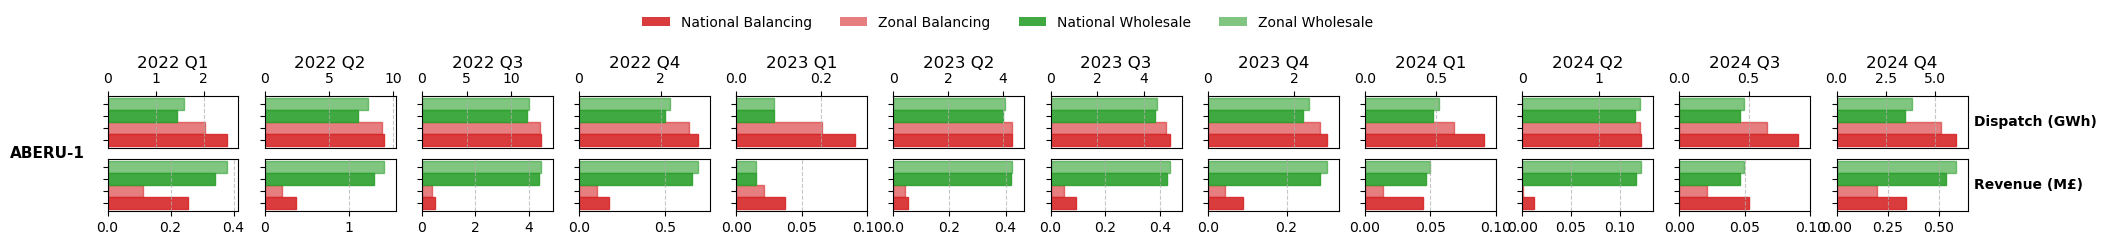

In [109]:
quarters.set_index(['unit', 'year', 'quarter']).drop(columns='period').sort_index()

# Create a grid of plots for ABERU-1 unit showing quarterly data
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# Filter data for ABERU-1
aberu_data = quarters[quarters['unit'] == 'ABERU-1'].sort_values(['year', 'quarter'])

# Create a figure with a grid layout
fig = plt.figure(figsize=(24, 1.5))
gs = gridspec.GridSpec(2, 12, figure=fig, hspace=0.2)  # Reduced space between rows

# Define colors for wholesale and balancing
wholesale_color = '#2ca02c'  # green
balancing_color = '#d62728'  # red
national_alpha = 0.9
zonal_alpha = 0.6

# Find global min and max for consistent scaling
dispatch_values = []
revenue_values = []
for _, row in quarters.iterrows():
    dispatch_values.extend([
        row['n_wholesale_dispatch'],
        row['z_wholesale_dispatch'],
        row['n_redispatch_dispatch'],
        row['z_redispatch_dispatch']
    ])
    revenue_values.extend([
        row['n_wholesale_revenue'],
        row['z_wholesale_revenue'],
        row['n_redispatch_revenue'],
        row['z_redispatch_revenue']
    ])

max_dispatch = max(abs(np.array(dispatch_values))) * 1.05e-3  # Convert to GWh with 5% margin
max_revenue = max(abs(np.array(revenue_values))) * 1.05e-6    # Convert to M£ with 5% margin

# Loop through each quarter and create subplots
for i, (_, row) in enumerate(aberu_data.iterrows()):
    if i >= 12:  # Limit to 12 quarters
        break
        
    # Create subplots for this quarter
    ax1 = fig.add_subplot(gs[0, i])  # Dispatch
    ax2 = fig.add_subplot(gs[1, i])  # Revenue
    
    period = f"{row['year']} Q{row['quarter']}"
    
    # Prepare data for dispatch - changed order to put redispatch first
    dispatch_data = np.array([
        row['n_redispatch_dispatch'],
        row['z_redispatch_dispatch'],
        row['n_wholesale_dispatch'],
        row['z_wholesale_dispatch']
    ]) * 1e-3
    
    # Prepare data for revenue - changed order to put redispatch first
    revenue_data = [
        row['n_redispatch_revenue']/1e6,
        row['z_redispatch_revenue']/1e6,
        row['n_wholesale_revenue']/1e6,
        row['z_wholesale_revenue']/1e6
    ]
    
    # Plot dispatch data
    y_pos = np.arange(4)
    labels = ['', '', '', '']
    # Changed order of colors to match the new data order
    colors = [
        balancing_color, 
        balancing_color, 
        wholesale_color, 
        wholesale_color
    ]
    alphas = [national_alpha, zonal_alpha, national_alpha, zonal_alpha]
    
    bars1 = ax1.barh(y_pos, dispatch_data, height=0.95, left=0)
    for bar, color, alpha in zip(bars1, colors, alphas):
        bar.set_color(color)
        bar.set_alpha(alpha)
    
    if i == 0:  # Only show labels on leftmost plot
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(labels)
    else:
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels([])
    
    # Move x-ticks to the top of the plot
    ax1.xaxis.tick_top()
    
    # Set title with additional padding to accommodate the top xticks
    ax1.set_title(f"{period}", pad=20)
    
    # Fix xlim issue - ensure we can see the data by using actual data range
    ax1_max = max(0.1, np.max(dispatch_data) * 1.1)  # Ensure minimum visible range
    ax1.set_xlim(0, ax1_max)
    
    # Add "Dispatch" label to the rightmost plot in the top row
    if i == 11:
        ax1.text(1.05, 0.5, 'Dispatch (GWh)', transform=ax1.transAxes, 
                 rotation=0, va='center', fontsize=10, fontweight='bold')
    
    # Plot revenue data
    bars2 = ax2.barh(y_pos, revenue_data, height=0.95, left=0)
    for bar, color, alpha in zip(bars2, colors, alphas):
        bar.set_color(color)
        bar.set_alpha(alpha)
    
    if i == 0:  # Only show labels on leftmost plot
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(labels)
    else:
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels([])
    
    # Fix xlim issue - ensure we can see the data by using actual data range
    ax2_max = max(0.1, np.max(revenue_data) * 1.1)  # Ensure minimum visible range
    ax2.set_xlim(0, ax2_max)
    
    # Add "Revenue (M£)" label to the rightmost plot in the bottom row
    if i == 11:
        ax2.text(1.05, 0.5, 'Revenue (M£)', transform=ax2.transAxes, 
                 rotation=0, va='center', fontsize=10, fontweight='bold')
    
    # Format axes
    for ax in [ax1, ax2]:
        ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add unit name vertically on the left side
fig.text(0.1, 0.5, 'ABERU-1', rotation=0, va='center', ha='center', 
         fontsize=11, fontweight='bold')

# Add legend for national and zonal with correct colors - updated order to match the plot
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=balancing_color, alpha=national_alpha, label='National Balancing'),
    Patch(facecolor=balancing_color, alpha=zonal_alpha, label='Zonal Balancing'),
    Patch(facecolor=wholesale_color, alpha=national_alpha, label='National Wholesale'),
    Patch(facecolor=wholesale_color, alpha=zonal_alpha, label='Zonal Wholesale')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=4, 
           bbox_to_anchor=(0.5, 1.5), frameon=False)

plt.show()

In [ ]:

# Show sample of the data
print(n_total.head().T.head().T)
print(z_total.head().T.head().T)

dispatch

In [137]:
idx = pd.IndexSlice

used_carriers = set()
n_total = n.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)

# remove units with 0 national revenue
n_total = n_total[n_total > 0]
zonal_total = z.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)

zonal_total.drop(intercon_lats.index.intersection(zonal_total.index), inplace=True)
n_total.drop(intercon_lats.index.intersection(n_total.index), inplace=True)

zonal_total = zonal_total.loc[n_total.index]

diff = zonal_total - n_total

In [139]:
n_total.loc[n_exp.index].mul(1e-6).sort_values(ascending=False).groupby(n_total.index.str[:4]).sum().sort_values(ascending=False)

ValueError: Grouper and axis must be same length

DRAX    8971.594908
PEMB    8816.544621
STAY    5628.116718
WBUR    4247.404049
GRAI    3572.422105
           ...     
SEVI       8.861005
BRID       7.355924
FELL       0.710681
BRGG            0.0
DERW            0.0
Length: 61, dtype: object

In [13]:
diff

ABERU-1   -4.722421e+05
ABRBO-1   -5.737347e+07
ABRTW-1   -2.280896e+07
ACHRW-1   -2.116440e+07
AFTOW-1   -2.539600e+07
               ...     
WLNYO-3   -2.688773e+06
WLNYO-4   -2.187920e+06
WLNYW-1    6.996761e+06
WTMSO-1    8.045033e+06
ZEN02A     1.158760e+05
Length: 404, dtype: float64

In [ ]:
hold = diff.to_frame().rename(columns={0: 'diff'})

hold['carrier'] = bmu_carriers[hold.index]

phold = hold.loc[hold['diff'] > 0]
phold = phold.groupby('carrier')['diff'].sum()

if phold.sum() > 0:
    phold /= phold.sum()

nhold = hold.loc[hold['diff'] < 0]
nhold = nhold.groupby('carrier')['diff'].sum().abs()

nhold /= nhold.sum()

nhold /= nhold.sum()
plus_mask = diff.loc[diff > 0].index

pos_total_change = np.around(diff.loc[plus_mask].sum() * 1e-9 / 3, decimals=2)
neg_total_change = np.around(diff.loc[diff < 0].sum() * 1e-9 / 3, decimals=2)

perc_change = (zonal_total / n_total) * 100 - 100

x = bmus.loc[n_total.index.intersection(bmus.index), 'lat'].astype(float)
perc_change = perc_change.loc[x.index]

def get_color(bmu):
    return carrier_colors[bmu_carriers[bmu]]

new_carriers = [bmu_carriers[bmu] for bmu in x.index]
used_carriers.update(new_carriers)

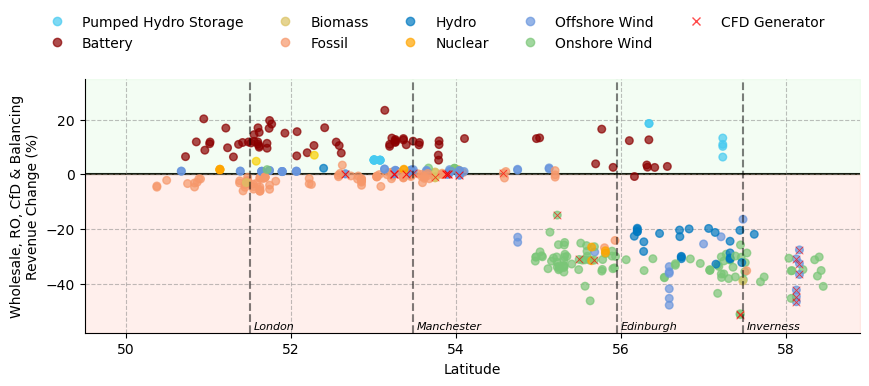

In [13]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(10, 3.3))

colors = list(map(get_color, x.index))

ax.scatter(
    x,
    perc_change,
    # label=factor,
    color=colors,
    s=30,
    alpha=0.7
    )

cfd_gens = x.index.intersection(cfd.index)
ax.scatter(
    x.loc[cfd_gens],
    perc_change.loc[cfd_gens],
    # label=factor,
    color='r',
    s=30,
    alpha=0.7,
    marker='x',
    linewidth=0.6
    )

ax.grid(True, linestyle='--', color='grey', alpha=0.5)
ax.set_axisbelow(True)
# ax.set_ylabel('Revenue Change (%)')
# ax.set_ylabel(nice_revenue_names[factor])
ax.set_ylabel('Wholesale, RO, CfD & Balancing\nRevenue Change (%)')

ax.axhline(0., c='k', zorder=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ylim_upper = 35
ylim_lower = -58

ax.set_ylim(ylim_lower, ylim_upper)
ax.set_xlim(49.5, 58.9)

ax.fill_between([49.5, 58.9], 0, ylim_upper, color='lightgreen', alpha=0.1, zorder=0)
ax.fill_between([49.5, 58.9], ylim_lower, 0, color='tomato', alpha=0.1, zorder=0)

# Build custom legend handles from the carriers that were used
legend_handles = []
legend_labels = []
for carrier in sorted(used_carriers):

    if carrier in ['cascade', 'solar']:
        continue

    # Get the color for this carrier; default to 'gray' if missing
    color = carrier_colors.get(carrier, 'gray')
    handle = Line2D([0], [0], marker='o', linestyle='None',
                    markerfacecolor=color, markersize=6, markeredgecolor=color,
                    alpha=0.7)

    legend_handles.append(handle)
    legend_labels.append(nice_carrier_names[carrier])


legend_handles.append(
    Line2D(
        [0], [0],
        marker='x',
        color='r',
        markersize=6,
        markeredgecolor='r',
        alpha=0.7,
        linewidth=0.6,
        linestyle='None'
        )
)
legend_labels.append('CFD Generator')

ax.axvline(51.5, c='k', linestyle='--', alpha=0.5)
ax.text(51.55, -55.8, 'London', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

ax.axvline(53.48, c='k', linestyle='--', alpha=0.5)
ax.text(53.53, -55.8, 'Manchester', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

ax.axvline(55.95, c='k', linestyle='--', alpha=0.5)
ax.text(56.0, -55.8, 'Edinburgh', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

ax.axvline(57.48, c='k', linestyle='--', alpha=0.5)
ax.text(57.53, -55.8, 'Inverness', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

ax.legend(
    legend_handles,
    legend_labels,
    loc='upper center',
    bbox_to_anchor=(0.45, 1.3),
    ncol=5,
    frameon=False)

ax.set_xlabel('Latitude')

plt.savefig('annual_unit_revenues_wholesale_ROC_CFD.pdf', bbox_inches='tight')
plt.show()

In [18]:
real_revs = pd.read_csv(
    Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex.csv', index_col=[0,1,2]
)
real_revs = real_revs.loc[~real_revs.index.get_level_values(0).isin(intercon_lats.index)]

In [19]:
real_revs

2022-01-01  2022-01-02  2022-01-03  2022-01-04  \
ABERU-1 national bid_cost       0.000000         0.0         0.0         0.0   
                 cfd            0.000000         0.0         0.0         0.0   
                 ftr            0.000000         0.0         0.0         0.0   
                 offer_cost  3830.038133         0.0         0.0         0.0   
                 roc            0.000000         0.0         0.0         0.0   
...                                  ...         ...         ...         ...   
LITRB-1 zonal    cfd                 NaN         NaN         NaN         NaN   
                 ftr                 NaN         NaN         NaN         NaN   
                 offer_cost          NaN         NaN         NaN         NaN   
                 roc                 NaN         NaN         NaN         NaN   
                 wholesale           NaN         NaN         NaN         NaN   

                             2022-01-05    2022-01-06  2022-01-07  2022-01-08  \
ABERU-1 national bid_cost           0.0      0.000000         0.0         0.0   
                 cfd                0.0      0.000000         0.0         0.0   
                 ftr                0.0      0.000000         0.0         0.0   
                 offer_cost         0.0  14998.122211         0.0         0.0   
                 roc                0.0      0.000000         0.0         0.0   
...                                 ...           ...         ...         ...   
LITRB-1 zonal    cfd                NaN           NaN         NaN         NaN   
                 ftr                NaN           NaN         NaN         NaN   
                 offer_cost         NaN           NaN         NaN         NaN   
                 roc                NaN           NaN         NaN         NaN   
                 wholesale          NaN           NaN         NaN         NaN   

                             2022-01-09  2022-01-10  ...  2024-12-22  \
ABERU-1 national bid_cost           0.0         0.0  ...    0.000000   
                 cfd                0.0         0.0  ...    0.000000   
                 ftr                0.0         0.0  ...    0.000000   
                 offer_cost         0.0         0.0  ...    0.000000   
                 roc                0.0         0.0  ...    0.000000   
...                                 ...         ...  ...         ...   
LITRB-1 zonal    cfd                NaN         NaN  ...    0.000000   
                 ftr                NaN         NaN  ...    0.000000   
                 offer_cost         NaN         NaN  ...    0.000000   
                 roc                NaN         NaN  ...    0.000000   
                 wholesale          NaN         NaN  ...    4.408099   

                             2024-12-23    2024-12-24    2024-12-25  \
ABERU-1 national bid_cost       0.00000      0.000000      0.000000   
                 cfd            0.00000      0.000000      0.000000   
                 ftr            0.00000      0.000000      0.000000   
                 offer_cost     0.00000  11024.723821  19482.769611   
                 roc            0.00000      0.000000      0.000000   
...                                 ...           ...           ...   
LITRB-1 zonal    cfd            0.00000      0.000000      0.000000   
                 ftr            0.00000      0.000000      0.000000   
                 offer_cost     0.00000      0.000000      0.000000   
                 roc            0.00000      0.000000      0.000000   
                 wholesale   4450.00015      0.000000     81.382891   

                              2024-12-26   2024-12-27   2024-12-28  \
ABERU-1 national bid_cost       0.000000     0.000000     0.000000   
                 cfd            0.000000     0.000000     0.000000   
                 ftr            0.000000     0.000000     0.000000   
                 offer_cost  5233.041156     0.000005  3967.088620   
                 roc        

In [20]:

ss = real_revs.sum(axis=1)

simple = ss.groupby(level=[0,1]).sum().unstack().dropna()
# simple['zonal'].div(simple['national']).hist()

perc_change_2 = (100 * simple['zonal'].div(simple['national']) - 100).clip(upper=0)
perc_change_3 = (100 * simple['equitable'].div(simple['national']) - 100).clip(upper=0)

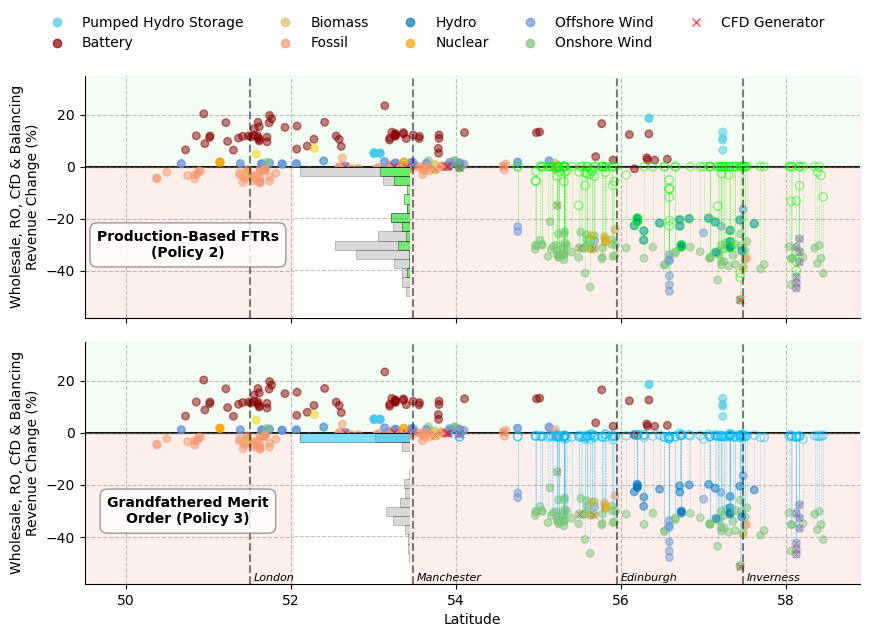

In [22]:
from matplotlib.lines import Line2D

# fig, axs = plt.subplots(3, 1, figsize=(10, 10))
fig, axs = plt.subplots(2, 1, figsize=(10, 6.6))

idx = pd.IndexSlice

used_carriers = set()

n_total = n.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)
n_total = n_total[n_total > 0]

# zonal_total = z.loc[idx[:,factor], :].replace(np.nan, 0).sum(axis=1)
# zonal_total.index = zonal_total.index.droplevel(1)
zonal_total = z.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)
zonal_total = zonal_total.loc[n_total.index]

zonal_total.drop(intercon_lats.index.intersection(zonal_total.index), inplace=True)
n_total.drop(intercon_lats.index.intersection(n_total.index), inplace=True)

diff = zonal_total - n_total

hold = diff.to_frame().rename(columns={0: 'diff'})

hold['carrier'] = bmu_carriers[hold.index]

phold = hold.loc[hold['diff'] > 0]
phold = phold.groupby('carrier')['diff'].sum()

if phold.sum() > 0:
    phold /= phold.sum()

    # if phold.sum() == 1 and len(phold) > 1:
    if len(phold) > 1:
        coords = [0.68, 0.9, 0.235, 0.05]
        plot_carrier_share(phold, ax, coords)

nhold = hold.loc[hold['diff'] < 0]
nhold = nhold.groupby('carrier')['diff'].sum().abs()

nhold /= nhold.sum()

# if nhold.sum() == 1 and len(nhold) > 1:
if len(nhold) > 1:
    coords = [0.1, 0.233, 0.255, 0.05]
    plot_carrier_share(nhold, ax, coords)


nhold /= nhold.sum()
plus_mask = diff.loc[diff > 0].index

pos_total_change = np.around(diff.loc[plus_mask].sum() * 1e-9 / 3, decimals=2)
neg_total_change = np.around(diff.loc[diff < 0].sum() * 1e-9 / 3, decimals=2)


perc_change = (zonal_total / n_total) * 100 - 100

x = bmus.loc[n_total.index.intersection(bmus.index), 'lat'].astype(float)
perc_change = perc_change.loc[x.index]

def get_color(bmu):
    return carrier_colors[bmu_carriers[bmu]]

new_carriers = [bmu_carriers[bmu] for bmu in x.index]
used_carriers.update(new_carriers)

colors = list(map(get_color, x.index))

    # print(x)
    # print(perc_change)

'''
ss = perc_change.loc[perc_change < 0]
mask = np.random.choice([True, False], size=len(ss), p=[0.6, 0.4])
ss2 = pd.Series(index=ss.index, dtype=float)
ss2[mask] = np.random.uniform(-1, 0, size=mask.sum())
for idx in ss.index[~mask]:
    ss2[idx] = np.random.uniform(0, ss[idx]/2)
ss3 = ss2.mul(0.1)
perc_change_2 = perc_change.copy()
perc_change_2.loc[ss.index] = ss2
perc_change_3 = perc_change.copy()
perc_change_3.loc[ss.index] = ss3
'''

for ax, policy_values, c, name in zip(
    axs,
    [perc_change_2, perc_change_3],
    [policy_colors['zonal'], policy_colors['zonal_with_policy']],
    ['Production-Based FTRs\n(Policy 2)', 'Grandfathered Merit\nOrder (Policy 3)']
    # ['Policy 2', 'Policy 3']
    ):
    
    ax.scatter(
        x,
        perc_change,
        # label=factor,
        color=colors,
        s=30,
        alpha=0.5
        )
    
    offset = 1.6

    intersection = perc_change.index.intersection(policy_values.index)
    for (x0, lower, upper) in zip(x.loc[intersection], perc_change.loc[intersection], policy_values.loc[intersection]):
        if lower > 0:
            continue
        ax.plot([x0, x0], [lower+offset, upper-offset], c=c, alpha=0.5, linestyle='--', linewidth=0.4)
        ax.scatter([x0], [upper], alpha=0.5, marker='o', facecolors='none', color=c)


    cfd_gens = x.index.intersection(cfd.index)
    ax.scatter(
        x.loc[cfd_gens],
        perc_change.loc[cfd_gens],
        # label=factor,
        color='r',
        s=30,
        alpha=0.4,
        marker='x',
        linewidth=0.6
        )

    ax.grid(True, linestyle='--', color='grey', alpha=0.5)
    ax.set_axisbelow(True)
    # ax.set_ylabel('Revenue Change (%)')
    # ax.set_ylabel(nice_revenue_names[factor])
    ax.set_ylabel('Wholesale, RO, CfD & Balancing\nRevenue Change (%)')

    ax.axhline(0., c='k', zorder=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ylim_upper = 35
    ylim_lower = -58

    ax.set_ylim(ylim_lower, ylim_upper)
    ax.set_xlim(49.5, 58.9)

    ax.fill_between([49.5, 58.9], 0, ylim_upper, color='lightgreen', alpha=0.1, zorder=0)
    ax.fill_between([49.5, 58.9], ylim_lower, 0, color='tomato', alpha=0.1, zorder=0)

    # Build custom legend handles from the carriers that were used
    legend_handles = []
    legend_labels = []
    for carrier in sorted(used_carriers):

        if carrier in ['cascade', 'solar']:
            continue

        # Get the color for this carrier; default to 'gray' if missing
        color = carrier_colors.get(carrier, 'gray')
        handle = Line2D([0], [0], marker='o', linestyle='None',
                        markerfacecolor=color, markersize=6, markeredgecolor=color,
                        alpha=0.7)

        legend_handles.append(handle)
        legend_labels.append(nice_carrier_names[carrier])


    legend_handles.append(
        Line2D(
            [0], [0],
            marker='x',
            color='r',
            markersize=6,
            markeredgecolor='r',
            alpha=0.7,
            linewidth=0.6,
            linestyle='None'
            )
    )
    legend_labels.append('CFD Generator')

    ax.axvline(51.5, c='k', linestyle='--', alpha=0.5)
    ax.axvline(53.48, c='k', linestyle='--', alpha=0.5)
    ax.axvline(55.95, c='k', linestyle='--', alpha=0.5)
    ax.axvline(57.48, c='k', linestyle='--', alpha=0.5)

    cover_share = abs(ax.get_ylim()[0]) / abs(ax.get_ylim()[1]-ax.get_ylim()[0])
    inset_ax = ax.inset_axes([0.27, 0.0, 0.15, cover_share])
    inset_ax.set_ylim(-60, 0.05)
    
    # Get negative values for histograms
    # neg_perc_change = perc_change[perc_change < 0]
    neg_perc_change = perc_change.copy()
    neg_policy_values = policy_values[policy_values < 0]
    
    # Plot histograms of negative revenue changes
    bins = np.linspace(min(neg_perc_change.min(), neg_policy_values.min()), 0, 15)
    # Calculate histogram values manually
    hist1, _ = np.histogram(neg_perc_change, bins=bins)
    hist2, _ = np.histogram(neg_policy_values, bins=bins)
    # Plot horizontal bars using the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    inset_ax.barh(bin_centers, -hist1, height=(bins[1]-bins[0]), alpha=0.3, color='gray',
                 label='Zonal w/o Reimbursement', edgecolor='black', linewidth=0.5)
    inset_ax.barh(bin_centers, -hist2, height=(bins[1]-bins[0]), alpha=0.5, color=c,
                 label=name, edgecolor='black', linewidth=0.5)
    
    inset_ax.set_yticks([])
    inset_ax.set_xticks([])
    # inset_ax.legend(loc='upper left', fontsize='x-small', title='Revenue Change (%)', title_fontsize='x-small')

    inset_ax.spines['right'].set_visible(False)
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['left'].set_visible(False)
    inset_ax.spines['bottom'].set_visible(False)

    inset_ax.axhline(0, c='k', linestyle='-', alpha=1, lw=1.15)
    inset_ax.axhline(-20.6, c='grey', linestyle='--', alpha=0.5, lw=0.75)
    inset_ax.axhline(-41.2, c='grey', linestyle='--', alpha=0.5, lw=0.75)

    # Add text with name in the lower left quarter with white frame
    text_box = ax.text(0.133, 0.3, name, transform=ax.transAxes, 
                      ha='center', va='center', fontsize=10, weight='bold')
    # Add white frame/background to the text
    text_box.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))


axs[1].text(51.55, -55.8, 'London', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')
axs[1].text(53.53, -55.8, 'Manchester', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')
axs[1].text(56.0, -55.8, 'Edinburgh', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')
axs[1].text(57.53, -55.8, 'Inverness', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

# Place the legend above the first axis (axs[0])
# axs[0].legend(
axs[0].legend(
    legend_handles,
    legend_labels,
    loc='upper center',
    bbox_to_anchor=(0.45, 1.3),
    ncol=5,
    frameon=False)

axs[0].set_xticklabels('')

axs[1].set_xlabel('Latitude')
# Adjust the spacing between the subplots to make the padding between upper and lower axes smaller
plt.subplots_adjust(hspace=0.1)  # Reduce the height space between subplots


plt.savefig('annual_policy_revenue_changes.pdf', bbox_inches='tight')
plt.show()

In [56]:
100 + neg_policy_values.mean()

98.81415648112183